In [103]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import nltk
from statistics import mode 
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import preprocessing

In [128]:
# data = pd.read_csv('debate_transcripts.csv') 
data = pd.read_csv('debate_transcripts_v3_2020-02-26.csv') # includes nevada and south carolina
data.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,"Good evening and welcome, the Democratic presi...",8.0
1,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And Super Tuesday is just a week away and this...,22.0
2,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,And CBS News is proud to bring you this debate...,14.0
3,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And we are partnering tonight also with Twitte...,10.0
4,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,"Now, here are the rules for the next two hours...",31.0


In [3]:
data.debate_name.unique()

array(['South Carolina Democratic Debate Transcript: February 25 Democratic Debate',
       'Democratic Debate Transcript: Las Vegas, Nevada Debate',
       'New Hampshire Democratic Debate Transcript',
       'January Iowa Democratic Debate Transcript',
       'December Democratic Debate Transcript: Sixth Debate from Los Angeles',
       "November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta",
       'October Democratic Debate Transcript: 4th Debate in Ohio',
       "September Houston Democratic Debate Transcript ' Third Debate",
       'Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019',
       'Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019',
       'Transcript from Night 2 of the First 2019 June Democratic Debates',
       'Transcript from Night 1 of the 2019 June Democratic Debates'],
      dtype=object)

In [4]:
data.speaker.unique()

array(["Norah O'Donnell", 'Gayle King', 'Bernie Sanders',
       'Michael Bloomberg', 'Pete Buttigieg', 'Elizabeth Warren',
       'Tom Steyer', 'Joe Biden', 'Amy Klobuchar', 'Bill Whitaker',
       'Major Garrett', 'Speaker 1', 'Margaret Brennan', 'Lester Holt',
       'Hallie Jackson', 'Chuck Todd', 'Female', 'Moderator',
       'Vanessa Hauc', 'Jon Ralston', 'Helen', 'Moderator 1',
       'Moderator 4', 'Audience', 'George S.', 'Andrew Yang',
       'Linsey Davis', 'David Muir', 'Monica Hernandez', 'Adam Sexton',
       'Devin Dwyer', 'Rachel Scott', 'Announcer', 'Wolf Blitzer',
       'Abby Phillips', 'B. Pfannenstiel', 'Moderator 2', 'Brianne P.',
       'Judy Woodruff', 'Amy Walter', 'Stephanie Sy', 'Speaker 2',
       'Tim Alberta', 'Amna Nawaz', 'Yamiche A.', 'Rachel Maddow',
       'Andrea Mitchell', 'Kamala Harris', 'Cory Booker',
       'Kristen Welker', 'Ashley Parker', 'Tulsi Gabbard', 'Speaker 3',
       'Anderson Cooper', 'Erin Burnett', 'Marc Lacey', 'Julian Castro',
  

In [5]:
# Michael bloomberg not included because Nevada debate not included in data set
# Other current candidates have been removed due to not being in the latest debates (like Tulsi Gabbard)
# Candidates that have dropped out are not included

top_candidates = ['Joe Biden', 'Bernie Sanders', 'Amy Klobuchar', 'Tom Steyer', 'Elizabeth Warren', 
                  'Pete Buttigieg', 'Michael Bloomberg']

In [6]:
# data = data.drop(columns="debate_section")
data.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,"Good evening and welcome, the Democratic presi...",8.0
1,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And Super Tuesday is just a week away and this...,22.0
2,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,And CBS News is proud to bring you this debate...,14.0
3,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And we are partnering tonight also with Twitte...,10.0
4,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O'Donnell,"Now, here are the rules for the next two hours...",31.0


In [130]:
data = data.loc[data['speaker'].isin(top_candidates)]
data.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
5,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Well, you're right, the economy is doing reall...",59.0
6,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,Senator-,5.0
8,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,I think that Donald Trump thinks it would be b...,19.0
9,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Oh, Mr. Bloomberg. Let me tell Mr. Putin. Okay...",27.0
11,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Pete Buttigieg,We know what the President ' what Russia wants...,3.0


## Get most frequent words for each candidate

In [8]:
freqWords = {}
wordCounts = {}

for candidate in top_candidates:
    candidate_data = data.loc[data['speaker'] == candidate]
    freqWords[candidate] = {}
    words = 0
    for line in candidate_data['speech']:
        for word in line.split():
            words += 1
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
            if word in freqWords[candidate]:
                freqWords[candidate][word] += 1
            else:
                freqWords[candidate][word] = 1
    wordCounts[candidate] = words
                
    freqWords[candidate] = sorted(freqWords[candidate].items(), key = lambda kv:(kv[1], kv[0]))
    freqWords[candidate].reverse()
                
# for candidate in freqWords:
#     print(candidate, freqWords[candidate][:50])
wordCounts

{'Joe Biden': 29010,
 'Bernie Sanders': 23478,
 'Amy Klobuchar': 25249,
 'Tom Steyer': 10809,
 'Elizabeth Warren': 27352,
 'Pete Buttigieg': 26037,
 'Michael Bloomberg': 4977}

In [9]:
# for candidate in freqWords:
#     print("----- ", candidate, " -----")
#     for word in freqWords[candidate][200:]:
#         print(word)
#     print()

In [10]:
wordProportions = {}

for candidate in top_candidates:
    wordProportions[candidate] = {}
    for word in freqWords[candidate]:
        wordProportions[candidate][word[0]] = word[1]/wordCounts[candidate]

wordProportions

{'Joe Biden': {'the': 0.05243019648397104,
  'to': 0.038366080661840746,
  'and': 0.024750086177180282,
  'i': 0.022612892106170287,
  'in': 0.021302998965873836,
  'that': 0.021130644605308516,
  'we': 0.020268872802481904,
  'of': 0.019269217511203033,
  'a': 0.017649086521889002,
  'it': 0.01368493622888659,
  'is': 0.013271285763529816,
  'have': 0.011478800413650465,
  'you': 0.010375732506032402,
  'be': 0.009031368493622889,
  'not': 0.008927955877283695,
  'what': 0.007687004481213375,
  'for': 0.007411237504308859,
  'with': 0.007238883143743537,
  'they': 0.007204412271630472,
  'on': 0.00672182006204757,
  'was': 0.006687349189934505,
  'fact': 0.006411582213029989,
  'this': 0.0062736987245777314,
  'do': 0.0060668734918993454,
  'he': 0.00579110651499483,
  'going': 0.005377456049638056,
  'people': 0.005205101689072734,
  'are': 0.005067218200620476,
  "that's": 0.004929334712168218,
  'get': 0.004722509479489831,
  'should': 0.004653567735263702,
  'my': 0.00455015511892

In [11]:
wordProportions['Pete Buttigieg']

{'the': 0.049890540384836965,
 'to': 0.04128739870184737,
 'that': 0.025886238813995467,
 'of': 0.025310135576295273,
 'and': 0.022583246917847678,
 'a': 0.021469447324960634,
 'we': 0.017974421016246113,
 'in': 0.017398317778545915,
 'is': 0.01639973883319891,
 'i': 0.013672850174751316,
 'this': 0.010984368398817067,
 'it': 0.010485078926143565,
 'for': 0.010177823866036793,
 'not': 0.009025617390636401,
 'on': 0.008603141682989592,
 'have': 0.00829588662288282,
 'be': 0.007950224680262703,
 'you': 0.007758190267695971,
 'but': 0.007066866382455736,
 'are': 0.006567576909782233,
 'with': 0.00649076314475554,
 'about': 0.006183508084648769,
 'what': 0.00606828743710873,
 'our': 0.005761032377001958,
 'as': 0.005607404846948573,
 'who': 0.004992894726735031,
 'president': 0.004992894726735031,
 'if': 0.004839267196681645,
 'was': 0.004608825901601567,
 "it's": 0.004532012136574874,
 'people': 0.004301570841494796,
 'do': 0.004301570841494796,
 'my': 0.00414794331144141,
 'just': 0.0041

## Idea: loop through each word in a sentence and add the probability of each word to a candidate's score (using naive bayes) - the candidate with the highest score is guessed as the speaker

In [12]:
data.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
5,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Well, you're right, the economy is doing reall...",59.0
6,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,Senator-,5.0
8,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,I think that Donald Trump thinks it would be b...,19.0
9,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Oh, Mr. Bloomberg. Let me tell Mr. Putin. Okay...",27.0
11,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Pete Buttigieg,We know what the President ' what Russia wants...,3.0


In [13]:
data['speaker'].value_counts() / len(data)

Joe Biden            0.197232
Elizabeth Warren     0.190311
Bernie Sanders       0.185986
Pete Buttigieg       0.169550
Amy Klobuchar        0.152682
Tom Steyer           0.062284
Michael Bloomberg    0.041955
Name: speaker, dtype: float64

In [14]:
speakerProbabilities = {'Joe Biden':0.217933,
                        'Elizabeth Warren':0.200498,
                        'Bernie Sanders':0.186800,
                        'Pete Buttigieg':0.171233,
                        'Amy Klobuchar':0.155044,
                        'Tom Steyer':0.068493}

## It might be easier to just loop through all words and create a new dataframe with each word and candidate label to work with the built-in naive bayes

In [15]:
tmpList = []
tmpList.append([])
tmpList.append([])

for candidate in top_candidates:
    candidate_data = data.loc[data['speaker'] == candidate]
    for line in candidate_data['speech']:
        for word in line.split():
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
#             row = pd.DataFrame([[word, candidate]], columns=['word','candidate'])
#             allWords.append(row, ignore_index=True)
            tmpList[0].append(word)
            tmpList[1].append(candidate)

allWords = pd.DataFrame(np.array(tmpList).T,columns=['word','candidate'])
# len(allWords)

In [16]:
allWords.head()

,word,candidate
0,we,Joe Biden
1,talk,Joe Biden
2,about,Joe Biden
3,progressive,Joe Biden
4,let's,Joe Biden


In [17]:
len(allWords)

146912

In [18]:
allWords['candidate'].value_counts()

Joe Biden            29010
Elizabeth Warren     27352
Pete Buttigieg       26037
Amy Klobuchar        25249
Bernie Sanders       23478
Tom Steyer           10809
Michael Bloomberg     4977
Name: candidate, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(allWords['word'], allWords['candidate'], test_size=0.25, random_state=0)

In [20]:
tmp = []

for i in range(len(allWords)):
    tmp.append(({'word':allWords['word'][i]},allWords['candidate'][i]))
               
tmp

display(tmp[0:20])
random.shuffle(tmp)
display(tmp[0:20])

train = tmp[:int(len(allWords) * 0.75)]
test = tmp[int(len(allWords) * 0.75):]

model_0 = nltk.NaiveBayesClassifier.train(tmp)

[({'word': 'we'}, 'Joe Biden'),
 ({'word': 'talk'}, 'Joe Biden'),
 ({'word': 'about'}, 'Joe Biden'),
 ({'word': 'progressive'}, 'Joe Biden'),
 ({'word': "let's"}, 'Joe Biden'),
 ({'word': 'talk'}, 'Joe Biden'),
 ({'word': 'about'}, 'Joe Biden'),
 ({'word': 'being'}, 'Joe Biden'),
 ({'word': 'progressive'}, 'Joe Biden'),
 ({'word': 'walking'}, 'Joe Biden'),
 ({'word': 'distance'}, 'Joe Biden'),
 ({'word': 'here'}, 'Joe Biden'),
 ({'word': 'is'}, 'Joe Biden'),
 ({'word': 'mother'}, 'Joe Biden'),
 ({'word': 'emanuel'}, 'Joe Biden'),
 ({'word': 'church'}, 'Joe Biden'),
 ({'word': 'nine'}, 'Joe Biden'),
 ({'word': 'people'}, 'Joe Biden'),
 ({'word': 'shot'}, 'Joe Biden'),
 ({'word': 'dead'}, 'Joe Biden')]

[({'word': 'evidence'}, 'Pete Buttigieg'),
 ({'word': 'all'}, 'Bernie Sanders'),
 ({'word': 'racist'}, 'Bernie Sanders'),
 ({'word': 'i'}, 'Amy Klobuchar'),
 ({'word': 'have'}, 'Amy Klobuchar'),
 ({'word': 'could'}, 'Joe Biden'),
 ({'word': 'you'}, 'Joe Biden'),
 ({'word': 'reasonable'}, 'Bernie Sanders'),
 ({'word': 'of'}, 'Amy Klobuchar'),
 ({'word': 'success'}, 'Amy Klobuchar'),
 ({'word': 'this'}, 'Amy Klobuchar'),
 ({'word': 'all'}, 'Elizabeth Warren'),
 ({'word': 'grew'}, 'Elizabeth Warren'),
 ({'word': 'every'}, 'Tom Steyer'),
 ({'word': 'died'}, 'Bernie Sanders'),
 ({'word': 'he'}, 'Amy Klobuchar'),
 ({'word': 'say'}, 'Elizabeth Warren'),
 ({'word': 'those'}, 'Joe Biden'),
 ({'word': 'phone'}, 'Joe Biden'),
 ({'word': 'and'}, 'Tom Steyer')]

In [21]:
print(model_0.classify({'word':'perspective'}))
print(model_0.classify({'word':'obama'}))
print(model_0.classify({'word':'1%'}))
print(model_0.classify({'word':'medicaid'}))
print(model_0.classify({'word':'prek'}))
print(model_0.classify({'word':'barack'}))

Pete Buttigieg
Joe Biden
Bernie Sanders
Amy Klobuchar
Elizabeth Warren
Joe Biden


In [22]:
# print(model_0.classify({'word':'courage'}))

In [23]:
for i in range(len(allWords)):
    if allWords['candidate'][i] == 'Pete Buttigieg':
        if model_0.classify({'word':allWords['word'][i]}) == 'Pete Buttigieg':
            print(allWords['word'][i])
#         else:
#             print('*** wrong')

president
it's
chaos
party
chaos
chaos
if
chaotic
divisive
toxic
exhausting
part
of
2020
sanders
like
meanwhile
home
from
south
south
bend
figure
of
us
because
it's
right
majority
an
majority
faster
of
but
majority
of
right
now
just
turn
president
actually
feel
of
through
roof
an
opportunity
different
because
it's
just
true
senator
sanders
believing
00:09:21]
something
most
of
by
right
charleston
alone
just
charleston
contributed
just
from
charleston
from
lifeblood
of
shouldn't
opportunity
if
you're
watching
right
now
support
peteforamericacom
chip
if
you're
watching
right
now
you're
your
but
if
like
defeat
peteforamericacom
maximum
of
$2800
if
you're
because
profiling
based
even
too
often
too
score
of
humility
because
of
issues
especially
racial
policing
own
community
humility
because
conscious
of
racial
none
of
us
experience
lived
experience
of
or
mall
feeling
eyes
us
us
as
without
thing
us
just
because
of
none
of
us
experience
black
drives
maternal
horrified
by
of
your
description
o

ready
now
galvanize
polarize
majority
lean
same
washington
playbook
alienate
forward
order
order
facing
issues
likes
of
barely
of
just
ago
asking
join
deliver
interested
labels
interested
interested
style
of
politics
forward
actually
turn
page
order
but
order
moment
next
president
challenges
likes
of
hadn't
even
of
or
ago
facing
president
could
like
challenge
by
familiar
or
moment
kind
of
unification
nominee
politics
if
politics
it's
or
because
we've
as
many
as
process
of
us
majority
it's
order
but
process
of
actually
proving
now
now
thinks
itself
by
streak
politics
of
inclusion
belonging
beats
shouldn't
even
if
of
it's
true
ready
historic
majority
right
now
even
broader
president
ago
now
majority
ready
such
thing
as
an
such
thing
as
an
unaffordable
just
as
command
accept
if
of
offering
campaigning
of
of
unionization
share
delivering
affordability
but
offering
game
transformations
actually
galvanize
polarize
order
it's
order
actually
of
just
consistent
throughout
delivering
as
experien

middleclass
target
subsidizing
of
tuition
of
of
scarce
01:23:52]
taxpayer
climate
such
climate
from
seeing
we've
seen
historic
floods
community
activate
center
01:38:04]
flood
same
thing
tornadoes
of
fire
place
longer
theoretical
longer
adapt
communities
resilient
ready
consequences
happen
or
but
ensure
worse
if
right
part
of
sometimes
feel
accepting
climate
science
defeat
whether
or
industrial
community
enlist
national
project
something
funds
supporting
li
funds
supporting
lives
inevitably
impacted
further
by
severity
frequency
by
factories
disproportionally
happens
black
equity
of
climate
forward
black
supporting
most
support
south
bend
it's
among
black
community
by
far
most
of
supporting
now
cochaired
by
of
black
support
right
from
of
most
recognizable
black
leaders
from
hart
of
waterloo
former
representative
berry
black
hawk
now
could
black
votes
granted
support
because
thinks
it's
because
of
facing
of
toughest
issues
communities
from
of
of
or
or
committee
but
ground
issues
from
po

wore
uniform
of
stake
decisions
oval
from
perspective
of
washington
city
might
but
frankly
live
infighting
capitol
hill
looks
usual
of
washington
looks
somebody
different
kind
of
experience
experience
ground
by
of
toughest
issues
recognizing
required
of
leadership
washington
washington
looking
like
communities
around
happen
'communities
shouldn't
of
shouldn't
place
support
but
ago
boone
bailout
but
rather
conservation'
by
isn't
even
if
you're
soybeans
you're
it's
just
president's
of
parts
of
worst
thing
socalled
refinery
waivers
ethanol
president
asking
but
benefit
from
as
usual
president
many
of
solutions
lie
but
just
support
but
something
supplies
from
product
farming
of
pillars
of
climate
quest
negative
could
as
as
symbol
of
climate
as
it's
an
important
part
of
message
around
climate
recruits
everybody
part
of
conservative
communities
of
feel
climate
science
acknowledging
part
of
but
reprioritize
as
particular
it's
just
although
certainly
runaway
it's
right
now
fraction
of
intention

tariffs
right
now
president
reduced
challenge
of
of
tariffs
tariffs
us
lack
of
bigger
strategy
dunford
dunford
september
12th
2019
could
serve
alive
9/11
an
endless
an
homeland
an
openended
of
ground
something
because
if
thing
we've
learned
from
it's
endless
avoid
place
president
an
authorization
of
force
builtin
threeyear
sunset
congress
required
president
required
congress
seek
an
authorization
because
if
summon
courage
overseas
least
members
of
congress
summon
courage
whether
ought
by
president
right
now
seems
as
props
or
worse
own
enrichment
flights
apparently
routed
through
scotland
just
hotels
as
officer
thing
through
your
eye
somebody
uniform
'do
down'
president
appoint
of
actually
believes
order
knowledge
your
fingertips
but
critical
emotional
learning
of
extremely
we've
just
teachers
we've
teaching
profession
always
of
from
south
bend
of
hosted
students
from
exam
become
regards
teachers
compensates
teachers
just
since
academically
but
fallback
teaching
profession
if
results
su

In [24]:
# from example code
print(nltk.classify.accuracy(model_0, test))

0.3251742539751688


## Given 1 word, our accuracy is almost 4% (around 2% after updated data) (old)
## Now, it's almost 30%!!

## Now, let's see if a vote-type system works better (count up predictions for a speech and see which candidate was most-often predicted)

In [25]:
# test

In [26]:
speeches = []

for candidate in top_candidates:
    candidate_data = data.loc[data['speaker'] == candidate]
    for line in candidate_data['speech']:
        words = []
        for word in line.split():
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "").replace("\"", "")
            words.append(({'word':word}, candidate))
        speeches.append(words)
        
# tmp[0][0][1]

In [27]:
len(speeches)

2312

In [28]:
num_correct = 0
for speech in speeches:
    word_predictions = []
    for word in speech:
        word_predictions.append(model_0.classify(word[0]))

    speech_prediction = mode(word_predictions)
    if speech_prediction == speech[0][1]:
        num_correct +=1
        
print(num_correct / len(speeches))

0.5410899653979239


## Cool, we got it up to ~38%, which I'll consider pretty good considering there are six candidates using a lot of similar language and talking about similar topics

## After fixing a bug (where we were failing to shuffle the training data...) accuracy is up over 50%!

Maybe accuracy could be improved by removing common words? - there seems to be a bias in these words to Joe Biden since he had the most speaking time

In [29]:
## we can try more words - I've tested most of these and each one seems to improve prediction accuracy

## replace with nltk.stopwords

# common_words = ['the','and','a','that','it','not','as','to','of','in','for','on','at',
#                 'by','up','but','they','or','an','will','would','their','there','be',
#                 'have','do','say','is','with','you','got','going',"don't","we're",'had',
#                 'change','medicare','can','we','my']

nltk.download('stopwords')

from nltk.corpus import stopwords

common_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/chase/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
common_words.remove('i')
common_words.remove('whom')
common_words.remove('but')
common_words.remove('while')
common_words.remove('himself')
common_words.remove('his')
common_words.remove('which')

common_words.append('change')
common_words.append('medicare')
common_words.append('can')
common_words.append('would')
common_words.append('say')
common_words.append('going')
common_words.append("we're")

In [31]:
common_words

['me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'who',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'if',
 'or',
 'because',
 'as',
 'until',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',

In [32]:
stripped_common_words = []
for word in common_words:
    word = word.replace("'", "")
    stripped_common_words.append(word)
stripped_common_words

['me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'youre',
 'youve',
 'youll',
 'youd',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'she',
 'shes',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'who',
 'this',
 'that',
 'thatll',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'if',
 'or',
 'because',
 'as',
 'until',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor'

In [33]:
max = 0
for speech in speeches:
    if len(speech) > max:
        max = len(speech)
        
max

265

In [34]:
num_correct = 0
num_predicted = len(speeches)
for speech in speeches:
    word_predictions = []
    for word in speech:
        if word[0]['word'] not in stripped_common_words:
            word_predictions.append(model_0.classify(word[0]))

    if (len(word_predictions)):
        speech_prediction = mode(word_predictions)
    else:
        speech_prediction = 'Joe Biden'
    
    if (len(speech) > 30): # Only looking at speeches with over x words - MAKE CHART FOR VARYING VALS HERE
        if speech_prediction == speech[0][1]:
            num_correct +=1
    else:
        num_predicted -= 1
        
print("num predicted: ", num_predicted)
print(num_correct / num_predicted)

num predicted:  1396
0.8495702005730659


    0-4       0       N/A # in other words, all 'speeches' in length <5 only contained 'common words'
    5-9       287     0.3554006968641115
    10-14     163     0.49693251533742333
    15-19     81      0.5679012345679012
    20-24     52      0.6346153846153846
    25-29     42      0.6904761904761905
    30-34     29      0.8620689655172413
    35-39     53      0.7169811320754716
    40-44     51      0.7450980392156863
    45-49     72      0.7272727272727273
    50-54     57      0.8596491228070176
    55-59     55      0.7636363636363637
    60-64     50      0.82
    65-69     52      0.6923076923076923
    70-74     58      0.8275862068965517
    75-79     70      0.7857142857142857
    80-84     48      0.7916666666666666
    85-89     65      0.8923076923076924
    90-94     65      0.8615384615384616
    95-99     60      0.7333333333333333
    100-104   56      0.75
    105-109   58      0.7413793103448276
    110-114   55      0.8909090909090909
    115-119   54      0.8333333333333334
    120-124   44      0.8863636363636364
    125-129   40      0.925
    130-134   35      0.8
    135-139   35      0.8857142857142857
    140-144   33      0.7878787878787878
    145-149   29      0.896551724137931
    150-154   34      0.7941176470588235
    155-159   25      0.8
    160-164   25      0.88
    165-169   23      0.9130434782608695
    170-174   15      0.8666666666666667
    175-179   21      1.0
    180-184   14      0.7142857142857143
    185-189   15      0.8
    190-194   5       1.0
    195-199   14      0.8571428571428571
    200-204   3       1.0
    205-209   3       1.0
    210-214   2       0.0
    215-219   0       N/A
    220-224   1       1.0
    225-229   0       N/A
    230-234   0       N/A
    235-239   0       N/A
    240-244   0       N/A
    245-249   0       N/A
    250-254   0       N/A
    255-259   1       1.0
    260-264   0       N/A
    265-269   1       0.0

    0   0.6591695501730104
    5   0.7058823529411765
    10  0.7638248847926268
    15  0.7914812460267006
    20  0.8036193029490617
    25  0.8097222222222222
    30  0.8133047210300429
    35  0.8122717311906501
    40  0.8161094224924013
    50  0.8222768222768223
    60  0.8232642019837692
    80  0.8339021615472128
    100 0.8377535101404057
    120 0.8564593301435407
    140 0.8446969696969697
    160 0.8671328671328671
    180 0.7966101694915254
    200 0.7272727272727273
    220 0.6666666666666666 # likely very few cases in this range

## Nice, we're over (50%,55%,70%) 84% accuracy!
There is a possibility of overfitting due to the trial and error formation of the common_words list. We'll see how accurate it is on new data

For responses longer than 40 words:

    num predicted:  1396
    0.8495702005730659

## TODO: predict nevada debate speeches

We could scrape from https://www.rev.com/blog/transcripts/democratic-debate-transcript-las-vegas-nevada-debate
and https://www.rev.com/blog/transcripts/south-carolina-democratic-debate-transcript-february-democratic-debate

### UPDATE: The dataset was updated - no need to scrape this data. Maybe we could test on town hall transcripts instead?

Currently at 46% on new data - maybe the last two debates are significantly different than previous debates

## Let's look at speaking % in each debate as well

I'm removing 'Michael Bloomberg' since he has not participated in most of the debates. We'll leave Steyer in since he has mostly been present.

In [36]:
data.columns

Index(['date', 'debate_name', 'debate_section', 'speaker', 'speech',
       'speaking_time_seconds'],
      dtype='object')

In [37]:
candidates = ['Joe Biden', 'Bernie Sanders', 'Amy Klobuchar', 'Tom Steyer', 'Elizabeth Warren', 
                  'Pete Buttigieg']

In [39]:
speakingTimes = {}

for debate in data['debate_name']:
    speakingTimes[debate] = {}
    for candidate in candidates:
        speakingTimes[debate][candidate] = 0

In [15]:
# tmpList = []
# tmpList.append([])
# tmpList.append([])

# for candidate in candidates:
#     candidate_data = data.loc[data['speaker'] == candidate]
#     for line in candidate_data['speech']:
#         for word in line.split():
#             word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
# #             row = pd.DataFrame([[word, candidate]], columns=['word','candidate'])
# #             allWords.append(row, ignore_index=True)
#             tmpList[0].append(word)
#             tmpList[1].append(candidate)

# allWords = pd.DataFrame(np.array(tmpList).T,columns=['word','candidate'])
# len(allWords)

In [43]:
for debate in data['debate_name']:
    for candidate in candidates:
        candidate_debate_data = data.loc[data['speaker'] == candidate].loc[data['debate_name'] == debate]
        for time in candidate_debate_data['speaking_time_seconds']:
            speakingTimes[debate][candidate] += time
#             print(debate, candidate)
speakingTimes

{'South Carolina Democratic Debate Transcript: February 25 Democratic Debate': {'Joe Biden': 277695.0,
  'Bernie Sanders': 330693.0,
  'Amy Klobuchar': 291489.0,
  'Tom Steyer': 150282.0,
  'Elizabeth Warren': 278784.0,
  'Pete Buttigieg': 280962.0},
 'Democratic Debate Transcript: Las Vegas, Nevada Debate': {'Joe Biden': 270970.0,
  'Bernie Sanders': 323449.0,
  'Amy Klobuchar': 324135.0,
  'Tom Steyer': 0,
  'Elizabeth Warren': 347116.0,
  'Pete Buttigieg': 292236.0},
 'New Hampshire Democratic Debate Transcript': {'Joe Biden': 222156.0,
  'Bernie Sanders': 226083.0,
  'Amy Klobuchar': 185504.0,
  'Tom Steyer': 155584.0,
  'Elizabeth Warren': 179333.0,
  'Pete Buttigieg': 206074.0},
 'January Iowa Democratic Debate Transcript': {'Joe Biden': 217116.0,
  'Bernie Sanders': 232878.0,
  'Amy Klobuchar': 219558.0,
  'Tom Steyer': 166722.0,
  'Elizabeth Warren': 251526.0,
  'Pete Buttigieg': 221334.0},
 'December Democratic Debate Transcript: Sixth Debate from Los Angeles': {'Joe Biden': 1

In [63]:
tmp = data.loc[data['debate_name'] == 'Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019'].loc[data['speaker'] == 'Elizabeth Warren']
fix_ew_time = 0
for time in tmp['speaking_time_seconds']:
    if not math.isnan(time):
        fix_ew_time += time
fix_ew_time
# Looks like time was not kept on 'Transcript from Night 1 of the 2019 June Democratic Debates'

985.0

In [47]:
speakingTimes_df = pd.DataFrame(speakingTimes)
speakingTimes_df.head()

,South Carolina Democratic Debate Transcript: February 25 Democratic Debate,"Democratic Debate Transcript: Las Vegas, Nevada Debate",New Hampshire Democratic Debate Transcript,January Iowa Democratic Debate Transcript,December Democratic Debate Transcript: Sixth Debate from Los Angeles,November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta,October Democratic Debate Transcript: 4th Debate in Ohio,September Houston Democratic Debate Transcript ' Third Debate,"Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019","Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019",Transcript from Night 2 of the First 2019 June Democratic Debates,Transcript from Night 1 of the 2019 June Democratic Debates
Joe Biden,277695.0,270970.0,222156.0,217116.0,154800.0,106820.0,227930.0,174247.0,77545.0,0.0,113458.0,0.0
Bernie Sanders,330693.0,323449.0,226083.0,232878.0,247200.0,98700.0,182850.0,138061.0,0.0,220706.0,92016.0,0.0
Amy Klobuchar,291489.0,324135.0,185504.0,219558.0,251600.0,90580.0,184920.0,102690.0,0.0,133985.0,0.0,NaN
Tom Steyer,150282.0,0.0,155584.0,166722.0,140800.0,70140.0,99590.0,0.0,0.0,0.0,0.0,0.0
Elizabeth Warren,278784.0,347116.0,179333.0,251526.0,267800.0,112700.0,310040.0,161370.0,0.0,NaN,0.0,NaN


In [49]:
# https://stackoverflow.com/questions/27817718/reverse-dataframe-column-order
# football[football.columns[::-1]]

speakingTimes_df = speakingTimes_df[speakingTimes_df.columns[::-1]]
speakingTimes_df

,Transcript from Night 1 of the 2019 June Democratic Debates,Transcript from Night 2 of the First 2019 June Democratic Debates,"Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019","Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019",September Houston Democratic Debate Transcript ' Third Debate,October Democratic Debate Transcript: 4th Debate in Ohio,November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta,December Democratic Debate Transcript: Sixth Debate from Los Angeles,January Iowa Democratic Debate Transcript,New Hampshire Democratic Debate Transcript,"Democratic Debate Transcript: Las Vegas, Nevada Debate",South Carolina Democratic Debate Transcript: February 25 Democratic Debate
Joe Biden,0.0,113458.0,0.0,77545.0,174247.0,227930.0,106820.0,154800.0,217116.0,222156.0,270970.0,277695.0
Bernie Sanders,0.0,92016.0,220706.0,0.0,138061.0,182850.0,98700.0,247200.0,232878.0,226083.0,323449.0,330693.0
Amy Klobuchar,NaN,0.0,133985.0,0.0,102690.0,184920.0,90580.0,251600.0,219558.0,185504.0,324135.0,291489.0
Tom Steyer,0.0,0.0,0.0,0.0,0.0,99590.0,70140.0,140800.0,166722.0,155584.0,0.0,150282.0
Elizabeth Warren,NaN,0.0,NaN,0.0,161370.0,310040.0,112700.0,267800.0,251526.0,179333.0,347116.0,278784.0
Pete Buttigieg,0.0,89886.0,150021.0,0.0,114589.0,177100.0,106820.0,221600.0,221334.0,206074.0,292236.0,280962.0


In [70]:
speakingTimes_df['Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019']['Elizabeth Warren'] = fix_ew_time
speakingTimes_df['Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019']['Bernie Sanders'] = 220706.0
speakingTimes_df['Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019']['Amy Klobuchar'] = 133985.0
speakingTimes_df['Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019']['Pete Buttigieg'] = 150021.0

speakingTimes_df

,Transcript from Night 1 of the 2019 June Democratic Debates,Transcript from Night 2 of the First 2019 June Democratic Debates,"Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019","Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019",September Houston Democratic Debate Transcript ' Third Debate,October Democratic Debate Transcript: 4th Debate in Ohio,November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta,December Democratic Debate Transcript: Sixth Debate from Los Angeles,January Iowa Democratic Debate Transcript,New Hampshire Democratic Debate Transcript,"Democratic Debate Transcript: Las Vegas, Nevada Debate",South Carolina Democratic Debate Transcript: February 25 Democratic Debate
Joe Biden,0.0,113458.0,0.0,77545.0,174247.0,227930.0,106820.0,154800.0,217116.0,222156.0,270970.0,277695.0
Bernie Sanders,0.0,92016.0,220706.0,220706.0,138061.0,182850.0,98700.0,247200.0,232878.0,226083.0,323449.0,330693.0
Amy Klobuchar,NaN,0.0,133985.0,133985.0,102690.0,184920.0,90580.0,251600.0,219558.0,185504.0,324135.0,291489.0
Tom Steyer,0.0,0.0,0.0,0.0,0.0,99590.0,70140.0,140800.0,166722.0,155584.0,0.0,150282.0
Elizabeth Warren,NaN,0.0,NaN,985.0,161370.0,310040.0,112700.0,267800.0,251526.0,179333.0,347116.0,278784.0
Pete Buttigieg,0.0,89886.0,150021.0,150021.0,114589.0,177100.0,106820.0,221600.0,221334.0,206074.0,292236.0,280962.0


In [78]:
speakingTimes_df = speakingTimes_df.drop(columns=['Transcript from Night 1 of the 2019 June Democratic Debates','Transcript from Night 2 of the First 2019 June Democratic Debates','Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019'])
speakingTimes_df

,"Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019",September Houston Democratic Debate Transcript ' Third Debate,October Democratic Debate Transcript: 4th Debate in Ohio,November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta,December Democratic Debate Transcript: Sixth Debate from Los Angeles,January Iowa Democratic Debate Transcript,New Hampshire Democratic Debate Transcript,"Democratic Debate Transcript: Las Vegas, Nevada Debate",South Carolina Democratic Debate Transcript: February 25 Democratic Debate
Joe Biden,77545.0,174247.0,227930.0,106820.0,154800.0,217116.0,222156.0,270970.0,277695.0
Bernie Sanders,220706.0,138061.0,182850.0,98700.0,247200.0,232878.0,226083.0,323449.0,330693.0
Amy Klobuchar,133985.0,102690.0,184920.0,90580.0,251600.0,219558.0,185504.0,324135.0,291489.0
Tom Steyer,0.0,0.0,99590.0,70140.0,140800.0,166722.0,155584.0,0.0,150282.0
Elizabeth Warren,985.0,161370.0,310040.0,112700.0,267800.0,251526.0,179333.0,347116.0,278784.0
Pete Buttigieg,150021.0,114589.0,177100.0,106820.0,221600.0,221334.0,206074.0,292236.0,280962.0


In [83]:
speakingTimes_df = speakingTimes_df.rename(columns={'Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019':'7-31-2019'})
speakingTimes_df.columns

Index(['7-31-2019',
       'September Houston Democratic Debate Transcript ' Third Debate',
       'October Democratic Debate Transcript: 4th Debate in Ohio',
       'November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta',
       'December Democratic Debate Transcript: Sixth Debate from Los Angeles',
       'January Iowa Democratic Debate Transcript',
       'New Hampshire Democratic Debate Transcript',
       'Democratic Debate Transcript: Las Vegas, Nevada Debate',
       'South Carolina Democratic Debate Transcript: February 25 Democratic Debate'],
      dtype='object')

In [84]:
speakingTimes_df = speakingTimes_df.rename(columns={'September Houston Democratic Debate Transcript \' Third Debate':'9-12-2019',
                                                   'October Democratic Debate Transcript: 4th Debate in Ohio':'10-15-2019',
                                                   'November Democratic Debate Transcript \' 5th Debate Transcript from Atlanta':'11-20-2019',
                                                   'December Democratic Debate Transcript: Sixth Debate from Los Angeles':'12-29-2019',
                                                   'January Iowa Democratic Debate Transcript':'1-14-2020',
                                                   'New Hampshire Democratic Debate Transcript':'2-7-2020',
                                                   'Democratic Debate Transcript: Las Vegas, Nevada Debate':'2-19-2020',
                                                   'South Carolina Democratic Debate Transcript: February 25 Democratic Debate':'2-25-2020'
                                                   })
speakingTimes_df

,7-31-2019,9-12-2019,10-15-2019,11-20-2019,12-29-2019,1-14-2020,2-7-2020,2-19-2020,2-25-2020
Joe Biden,77545.0,174247.0,227930.0,106820.0,154800.0,217116.0,222156.0,270970.0,277695.0
Bernie Sanders,220706.0,138061.0,182850.0,98700.0,247200.0,232878.0,226083.0,323449.0,330693.0
Amy Klobuchar,133985.0,102690.0,184920.0,90580.0,251600.0,219558.0,185504.0,324135.0,291489.0
Tom Steyer,0.0,0.0,99590.0,70140.0,140800.0,166722.0,155584.0,0.0,150282.0
Elizabeth Warren,985.0,161370.0,310040.0,112700.0,267800.0,251526.0,179333.0,347116.0,278784.0
Pete Buttigieg,150021.0,114589.0,177100.0,106820.0,221600.0,221334.0,206074.0,292236.0,280962.0


In [95]:
# sns.lineplot(data=speakingTimes_df)
speakingProportions_df = speakingTimes_df
for col in speakingProportions_df.columns:
    debate_total = 0
    for time in speakingProportions_df[col]:
        debate_total += time
    for i in range(len(speakingProportions_df[col])):
        speakingProportions_df[col][i] /= debate_total
speakingProportions_df

,7-31-2019,9-12-2019,10-15-2019,11-20-2019,12-29-2019,1-14-2020,2-7-2020,2-19-2020,2-25-2020
Joe Biden,0.132955,0.252182,0.192764,0.182361,0.120580,0.165847,0.189112,0.173932,0.172492
Bernie Sanders,0.378412,0.199811,0.154639,0.168499,0.192553,0.177887,0.192455,0.207618,0.205411
Amy Klobuchar,0.229725,0.148620,0.156390,0.154637,0.195981,0.167712,0.157911,0.208058,0.181060
Tom Steyer,0.000000,0.000000,0.084225,0.119742,0.109674,0.127353,0.132442,0.000000,0.093348
Elizabeth Warren,0.001689,0.233546,0.262206,0.192400,0.208599,0.192132,0.152658,0.222809,0.173168
Pete Buttigieg,0.257219,0.165841,0.149776,0.182361,0.172613,0.169069,0.175422,0.187583,0.174521


In [97]:
speakingProportions_df = speakingProportions_df.rename(columns={
    '7-31-2019':0,
    '9-12-2019':1,
    '10-15-2019':2,
    '11-20-2019':3,
    '12-29-2019':4,
    '1-14-2020':5,
    '2-7-2020':6,
    '2-19-2020':7,
    '2-25-2020':8})
speakingProportions_df

,0,1,2,3,4,5,6,7,8
Joe Biden,0.132955,0.252182,0.192764,0.182361,0.120580,0.165847,0.189112,0.173932,0.172492
Bernie Sanders,0.378412,0.199811,0.154639,0.168499,0.192553,0.177887,0.192455,0.207618,0.205411
Amy Klobuchar,0.229725,0.148620,0.156390,0.154637,0.195981,0.167712,0.157911,0.208058,0.181060
Tom Steyer,0.000000,0.000000,0.084225,0.119742,0.109674,0.127353,0.132442,0.000000,0.093348
Elizabeth Warren,0.001689,0.233546,0.262206,0.192400,0.208599,0.192132,0.152658,0.222809,0.173168
Pete Buttigieg,0.257219,0.165841,0.149776,0.182361,0.172613,0.169069,0.175422,0.187583,0.174521


In [99]:
speakingProportions_df = speakingProportions_df.rename(index={
    'Joe Biden':0,
    'Bernie Sanders':1,
    'Amy Klobuchar':2,
    'Tom Steyer':3,
    'Elizabeth Warren':4,
    'Pete Buttigieg':5,
    })
speakingProportions_df

,0,1,2,3,4,5,6,7,8
0,0.132955,0.252182,0.192764,0.182361,0.120580,0.165847,0.189112,0.173932,0.172492
1,0.378412,0.199811,0.154639,0.168499,0.192553,0.177887,0.192455,0.207618,0.205411
2,0.229725,0.148620,0.156390,0.154637,0.195981,0.167712,0.157911,0.208058,0.181060
3,0.000000,0.000000,0.084225,0.119742,0.109674,0.127353,0.132442,0.000000,0.093348
4,0.001689,0.233546,0.262206,0.192400,0.208599,0.192132,0.152658,0.222809,0.173168
5,0.257219,0.165841,0.149776,0.182361,0.172613,0.169069,0.175422,0.187583,0.174521


In [101]:
## Example code: l2-charts
# club250 = playerHits[playerHits.H >= 250].playerID.unique()
# club250
# plt.figure(figsize=(14, 6))
# for playerID in club250:
#     data = playerHits[playerHits.playerID == playerID]
#     firstRow = data.iloc[0]
#     name = '{}, {}'.format(firstRow.nameLast, firstRow.nameFirst)
# #     print(name)
#     sns.lineplot('yearID', 'H', data=data, label=name)
    
# plt.xlim((1910, 1945))
    
# plt.legend()

# plt.savefig('club250.pdf')
# plt.savefig('club250')

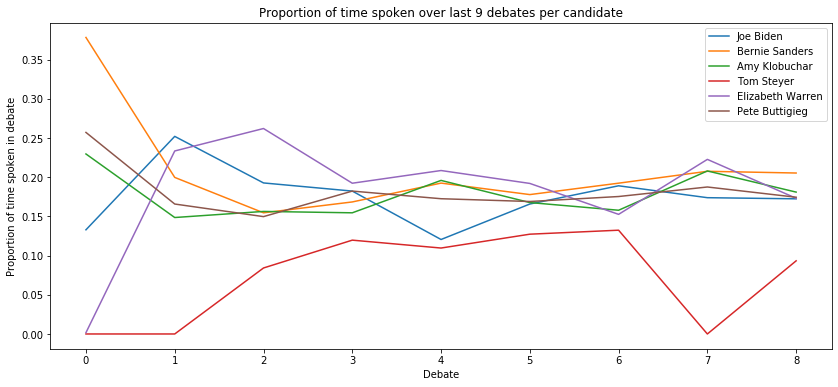

In [126]:
plt.figure(figsize=(14, 6))
plt.title("Proportion of time spoken over last 9 debates per candidate")

# Other candidates not taken into consideration... Actual proportions are actually slightly smaller

sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[0])
sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[1])
sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[2])
sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[3])
sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[4])
sns.lineplot([0,1,2,3,4,5,6,7,8],speakingProportions_df.loc[5])

plt.ylabel('Proportion of time spoken in debate')    
plt.xlabel('Debate')


plt.legend(candidates);

## Let's train on all of the data minus a specific debate and predict on each debate

We can compare debate accuracies and determine which were most predictable and which debates were most different from the others

### First, let's predict the first debate and train on the other 8

The first few debates will be pretty weird since they were split into two nights each and there were a lot of different candidates in the race.

In [152]:
total_correct = 0
total_predicted = 0
for debate in data['debate_name'].unique():
    train_df = data.loc[data['debate_name'] != debate]
    test_df = data.loc[data['debate_name'] == debate]
    
    # Get list of words to train on
    trList = []
    trList.append([])
    trList.append([])
    
    teList = []
    teList.append([])
    teList.append([])

    for candidate in candidates:
        candidate_train_data = train_df.loc[data['speaker'] == candidate]
        for line in candidate_train_data['speech']:
            for word in line.split():
                word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
                trList[0].append(word)
                trList[1].append(candidate)
                
        candidate_test_data = test_df.loc[data['speaker'] == candidate]
        for line in candidate_test_data['speech']:
            for word in line.split():
                word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
                teList[0].append(word)
                teList[1].append(candidate)

    trainWords = pd.DataFrame(np.array(trList).T,columns=['word','candidate'])
    testWords = pd.DataFrame(np.array(teList).T,columns=['word','candidate'])
    
    train_reformatted = []
    test_reformatted = []
    
    # Format into tuple for use in model

    for i in range(len(trainWords)):
        train_reformatted.append(({'word':trainWords['word'][i]},trainWords['candidate'][i]))
        
    for i in range(len(testWords)):
        test_reformatted.append(({'word':testWords['word'][i]},testWords['candidate'][i]))

    model = nltk.NaiveBayesClassifier.train(train_reformatted)
    
    
#     print('--- ', debate, ' ---')
#     print(model.classify({'word':'perspective'}))
#     print(model.classify({'word':'obama'}))
#     print(model.classify({'word':'1%'}))
#     print(model.classify({'word':'medicaid'}))
#     print(model.classify({'word':'prek'}))
#     print(model.classify({'word':'barack'}))
#     print()

    test_speeches = []

    for candidate in candidates:
        candidate_data = test_df.loc[data['speaker'] == candidate]
        for line in candidate_data['speech']:
            words = []
            for word in line.split():
                word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "").replace("\"", "")
                words.append(({'word':word}, candidate))
            test_speeches.append(words)
            
            
    num_correct = 0
    num_predicted = len(test_speeches)
    for speech in test_speeches:
        word_predictions = []
        for word in speech:
            if word[0]['word'] not in stripped_common_words:
                word_predictions.append(model_0.classify(word[0]))

        if (len(word_predictions)):
            speech_prediction = mode(word_predictions)
        else:
            speech_prediction = model_0.classify({'word':'the'})

        if (len(speech) > 120): # Only looking at speeches with over x words - MAKE CHART FOR VARYING VALS HERE
            if speech_prediction == speech[0][1]:
                num_correct +=1
        else:
            num_predicted -= 1

    total_correct += num_correct
    total_predicted += num_predicted
#     print('--- ', debate, ' ---')
#     print("num predicted: ", num_predicted)
#     if num_predicted > 0:
#         print(num_correct / num_predicted)
#     print()
print(total_correct / total_predicted)

0.9113924050632911


## Accuracy per debate (predicting on all responses) (0.7160270880361174)

    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  319
    0.5830721003134797

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  290
    0.6862068965517242

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  187
    0.7272727272727273

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  222
    0.7027027027027027

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  200
    0.735

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  140
    0.7571428571428571

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  230
    0.7086956521739131

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  163
    0.8404907975460123

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  65
    0.8307692307692308

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  211
    0.7156398104265402

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  142
    0.823943661971831

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  46
    0.7391304347826086


## Accuracy per debate (discarding answers less than 20 words in length) (0.8699300699300699)


    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  119
    0.8403361344537815

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  139
    0.9136690647482014

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  152
    0.8355263157894737

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  186
    0.7688172043010753

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  149
    0.8389261744966443

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  113
    0.8672566371681416

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  139
    0.8920863309352518

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  124
    0.9435483870967742

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  44
    1.0

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  129
    0.8992248062015504

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  100
    0.93

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  36
    0.8333333333333334

## Accuracy per debate (discarding answers less than 30 words in length) (0.879080118694362)

    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  108
    0.8518518518518519

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  124
    0.9193548387096774

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  150
    0.84

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  182
    0.7747252747252747

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  144
    0.8402777777777778

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  111
    0.8648648648648649

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  129
    0.9147286821705426

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  116
    0.9655172413793104

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  41
    1.0

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  120
    0.9416666666666667

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  89
    0.9213483146067416

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  34
    0.8529411764705882
    
   
## Accuracy per debate (discarding answers less than 60 words in length) (0.8872180451127819)
    
    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  86
    0.8372093023255814

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  100
    0.93

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  140
    0.8571428571428571

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  136
    0.8088235294117647

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  134
    0.8432835820895522

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  100
    0.88

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  108
    0.9074074074074074

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  94
    0.9680851063829787

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  29
    1.0

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  73
    0.9863013698630136

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  38
    0.9736842105263158

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  26
    0.8076923076923077
    
## Accuracy per debate (discarding answers less than 90 words in length) (0.8866120218579235)

    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  65
    0.8923076923076924

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  63
    0.9682539682539683

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  112
    0.8482142857142857

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  85
    0.8235294117647058

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  114
    0.8508771929824561

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  73
    0.8493150684931506

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  85
    0.9058823529411765

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  58
    0.9655172413793104

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  21
    1.0

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  31
    0.967741935483871

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  11
    1.0

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  14
    0.7857142857142857
    
## Accuracy per debate (discarding answers less than 120 words in length) (0.9113924050632911)

    ---  South Carolina Democratic Debate Transcript: February 25 Democratic Debate  ---
    num predicted:  44
    0.9318181818181818

    ---  Democratic Debate Transcript: Las Vegas, Nevada Debate  ---
    num predicted:  30
    0.9666666666666667

    ---  New Hampshire Democratic Debate Transcript  ---
    num predicted:  71
    0.8732394366197183

    ---  January Iowa Democratic Debate Transcript  ---
    num predicted:  41
    0.8048780487804879

    ---  December Democratic Debate Transcript: Sixth Debate from Los Angeles  ---
    num predicted:  68
    0.9117647058823529

    ---  November Democratic Debate Transcript ' 5th Debate Transcript from Atlanta  ---
    num predicted:  34
    0.9411764705882353

    ---  October Democratic Debate Transcript: 4th Debate in Ohio  ---
    num predicted:  57
    0.9298245614035088

    ---  September Houston Democratic Debate Transcript ' Third Debate  ---
    num predicted:  26
    1.0

    ---  Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019  ---
    num predicted:  7
    1.0

    ---  Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019  ---
    num predicted:  9
    0.8888888888888888

    ---  Transcript from Night 2 of the First 2019 June Democratic Debates  ---
    num predicted:  4
    1.0

    ---  Transcript from Night 1 of the 2019 June Democratic Debates  ---
    num predicted:  4
    0.75


## Let's take 40 debate quotes - 10 each from Trump, Clinton, Obama, and Romney - and see which of the current candidates our model predicts said the quote

In [164]:
other_data = pd.read_csv('other_debates.csv') # other presidential candidates
# other_data['Candidate'][1]
other_candidates = other_data['Candidate'].unique()
other_candidates

array(['Hillary Clinton', 'Donald Trump', 'Barack Obama', 'Mitt Romney'],
      dtype=object)

In [165]:
other_data.head()

,Speech,Candidate
0,"Well, thank you, Lester, and thanks to Hofstra...",Hillary Clinton
1,I also want to see more companies do profit-sh...,Hillary Clinton
2,"Well, I think that trade is an important issue...",Hillary Clinton
3,Nine million people -- nine million people los...,Hillary Clinton
4,And I think it's important that we grip this a...,Hillary Clinton


In [191]:
total_correct = 0
total_predicted = 0

train_df = data
test_df = other_data

# Get list of words to train on
trList = []
trList.append([])
trList.append([])

teList = []
teList.append([])
teList.append([])

for candidate in candidates:
    candidate_train_data = train_df.loc[data['speaker'] == candidate]
    for line in candidate_train_data['speech']:
        for word in line.split():
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "")
            trList[0].append(word)
            trList[1].append(candidate)

for candidate in other_candidates:
    candidate_test_data = test_df.loc[other_data['Candidate'] == candidate]
    for line in candidate_test_data['Speech']:
        for word in line.split():
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "").replace("\\", "")
            teList[0].append(word)
            teList[1].append(candidate)

trainWords = pd.DataFrame(np.array(trList).T,columns=['word','candidate'])
testWords = pd.DataFrame(np.array(teList).T,columns=['word','candidate'])

train_reformatted = []
test_reformatted = []

# Format into tuple for use in model

for i in range(len(trainWords)):
    train_reformatted.append(({'word':trainWords['word'][i]},trainWords['candidate'][i]))

for i in range(len(testWords)):
    test_reformatted.append(({'word':testWords['word'][i]},testWords['candidate'][i]))

model = nltk.NaiveBayesClassifier.train(train_reformatted)

test_speeches = []

for candidate in other_candidates:
    candidate_data = test_df.loc[test_df['Candidate'] == candidate]
    for line in candidate_data['Speech']:
        words = []
        for word in line.split():
            word = word.lower().replace(",", "").replace(".", "").replace("?", "").replace("-", "").replace("\"", "")
            words.append(({'word':word}, candidate))
        test_speeches.append(words)

max_length = 0
tmp_length = 0
# for speech in test_speeches:
speech = test_speeches[19]
word_predictions = []
tmp_length = 0
for word in speech:
    if word[0]['word'] not in stripped_common_words and len(word[0]['word']) > 0:
        word_predictions.append(model_0.classify(word[0]))
    else:
        word_predictions.append("COMMON")
print(word_predictions)
print(speech)
speech_prediction = mode(word_predictions)
print("Predicted: ", speech_prediction, " Actual: ", speech[0][1])

#     break
            

#     speech_prediction = mode(word_predictions)

#     print("Predicted: ", speech_prediction, " Actual: ", speech[0][1])
# print(max_length)

['Amy Klobuchar', 'Amy Klobuchar', 'Joe Biden', 'Elizabeth Warren', 'COMMON', 'Joe Biden', 'COMMON', 'COMMON', 'Pete Buttigieg', 'Joe Biden', 'COMMON', 'Elizabeth Warren', 'COMMON', 'Joe Biden', 'COMMON', 'COMMON', 'COMMON', 'Joe Biden', 'COMMON', 'COMMON', 'Joe Biden', 'Joe Biden', 'COMMON', 'COMMON', 'COMMON', 'Joe Biden', 'Pete Buttigieg', 'COMMON', 'COMMON', 'Joe Biden', 'COMMON', 'COMMON', 'Amy Klobuchar', 'Bernie Sanders', 'COMMON', 'COMMON', 'COMMON', 'COMMON', 'COMMON', 'Elizabeth Warren', 'Bernie Sanders', 'COMMON', 'Amy Klobuchar', 'Joe Biden', 'COMMON', 'Joe Biden', 'Joe Biden', 'Elizabeth Warren', 'Joe Biden', 'COMMON', 'Joe Biden', 'COMMON', 'Elizabeth Warren', 'COMMON', 'COMMON', 'COMMON', 'COMMON', 'Tom Steyer', 'Bernie Sanders', 'COMMON', 'COMMON', 'Joe Biden', 'COMMON', 'Bernie Sanders', 'COMMON', 'Amy Klobuchar', 'COMMON', 'Amy Klobuchar', 'Bernie Sanders', 'COMMON', 'COMMON', 'Bernie Sanders', 'COMMON', 'Joe Biden', 'COMMON', 'Joe Biden', 'Bernie Sanders', 'COMMON', 


    Predicted:  Elizabeth Warren  Actual:  Hillary Clinton
    Predicted:  Elizabeth Warren  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    Predicted:  Elizabeth Warren  Actual:  Hillary Clinton
    Predicted:  Elizabeth Warren  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    Predicted:  Joe Biden  Actual:  Hillary Clinton
    
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    Predicted:  Joe Biden  Actual:  Donald Trump
    
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Elizabeth Warren  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    Predicted:  Joe Biden  Actual:  Barack Obama
    
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney
    Predicted:  Joe Biden  Actual:  Mitt Romney